In [ ]:
def plot_later():
    # (optional) Display first-level results in the brain space
    _, threshold = map_threshold(
        z_map, 
        level=.05, 
        height_control='fpr')

    plot_stat_map(
        z_map, 
        bg_img=anat_img,
        threshold=3,
        display_mode='z')

## First level GLM analysis

This script performs subject level modeling of BOLD response. For each subject and condition, single GLM matrix is created and associated beta values are estimated. Script features: 
- loads preprocessed fMRI data

---
**Last update**: 07.02.2020 

In [1]:
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib

from bids import BIDSLayout
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
from nistats.first_level_model import FirstLevelModel
from nistats.reporting import plot_design_matrix
from nistats.thresholding import map_threshold
from nistats.design_matrix import make_first_level_design_matrix

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data                    
from dn_utils.glm_utils import Regressor, my_make_first_level_design_matrix
from dn_utils.misc import mkdir_safe

/home/kmb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh)
n_subjects, n_conditions, n_trials, _ = beh.shape

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


### Query neuroimaging dataset

Using BIDSLayout object query BIDS dataset to pull out necessary files.
- `anat_files`: sorted list of preprocessed T1w images
- `fmri_files`: list of two lists containing sorted (by subject number) paths to imaging files, first list corresponds to reward condition of PRL task and second list corresponds to punishment condition of PRL task
- `conf_files`: list of two lists containing sorted (by subject number) paths to confound files
- `mask_files`: brain mask files for fmri sequencnes

In [7]:
path_bids = os.path.join(path_root, 'data/main_fmri_study')

layout = BIDSLayout(
    root=path_bids,
    derivatives=True,
    validate=True,
    index_metadata=False
)

anat_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "T1w",
    "desc": "preproc",
    "return_type": "filename"
}

fmri_filter = {
    "extension": [".nii", ".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "bold",
    "desc": "preproc",
    "return_type": "filename"
}

conf_filter = {
    "extension": "tsv",
    "desc": "confounds",
    "return_type": "filename"
}

mask_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "desc": "brain",
    "suffix": "mask",
    "return_type": "filename"
}

anat_files = layout.get(**anat_filter)

fmri_files, conf_files, mask_files = [], [], []

for task_dict in [{"task": "prlrew"}, {"task": "prlpun"}]:
    fmri_filter.update(task_dict)
    conf_filter.update(task_dict)
    mask_filter.update(task_dict)
    fmri_files.append(layout.get(**fmri_filter))
    conf_files.append(layout.get(**conf_filter))
    mask_files.append(layout.get(**mask_filter))

### Load task modulations
Here, modulations for model-based fMRI are downloaded. Two modulations apply to decision phase (expected probability of choosing correct box `wcor` and Pascalian expected value `exvl`) and one modulation apply to outcome phase (probabilistic prediction error `perr`).

In [8]:
path_modulations = os.path.join(path_root, 
                                'data/main_fmri_study/derivatives/nistats/modulations')

# Load parametric modulations
modulations_wcor = np.load(os.path.join(path_modulations,'modulations_wcor.npy'))
modulations_exvl = np.load(os.path.join(path_modulations,'modulations_exvl.npy'))
modulations_perr = np.load(os.path.join(path_modulations,'modulations_perr.npy'))

### Single subject analysis

Here, first level GLM analysis is performed for each subject and task condition. `FirstLevelModel` instance is created initialized with proper GLM settings (hemodynamic response function, drift and noise model, high pass filter, smoothing kernel). Then, for each imaging sequence following steps are applied:
1. Data files are loaded (T1w anatomical image, EPI sequence, brain mask for EPI sequence, confounds table.
2. Task events onsets are loaded.
    - `onset_dec`: onset time of decision phase
    - `onset_res`: onset time of subject response
    - `onset_out`: onset time of outcome phase

In [9]:
# Directory for storing output nistats derivatives
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats/first_level')
mkdir_safe(path_out)

# Specify GLM
fmri_glm = FirstLevelModel(
    t_r=2,
    hrf_model='spm',
    drift_model='cosine',
    noise_model='ar1',
    high_pass=0.0078125, 
    standardize=True,
    smoothing_fwhm=6)

# Name of relevant confounds
confounds_relevant = [col for col in pd.read_csv(conf_files[0][0], sep='\t').columns 
                      if 'rot' in col or 'trans' in col]

# Times of image acquisition in seconds
n_scans, t_r = 730, 2
frame_times = np.arange(n_scans) * t_r

In [32]:
# for sub_idx in range(n_subjects):
#     for con_idx in range(n_conditions):
sub_idx = 0
con_idx = 0

# Load subject data
anat_img = nib.load(anat_files[sub_idx])
fmri_img = nib.load(fmri_files[con_idx][sub_idx])
fmri_glm.mask = nib.load(mask_files[0][0])
fmri_glm.subject_label = meta['dim1'][sub_idx]
confounds = pd.read_csv(conf_files[con_idx][sub_idx], sep='\t')
confounds = confounds[confounds_relevant]
confounds.index = frame_times # Standard time representation (in seconds)

# Setup events
resp_type = beh[sub_idx, con_idx, :, meta['dim4'].index('response')]
onset_dec = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_dec')] 
onset_res = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_dec')] + \
            beh[sub_idx, con_idx, :, meta['dim4'].index('rt')]
onset_out = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_out')]

modulation_wcor = modulations_perr[sub_idx, con_idx, resp_type != 0]
modulation_exvl = modulations_perr[sub_idx, con_idx, resp_type != 0]
modulation_perr = modulations_perr[sub_idx, con_idx, resp_type != 0]

modulation_wcor_demeaned = modulation_wcor - np.mean(modulation_wcor)
modulation_exvl_demeaned = modulation_exvl - np.mean(modulation_exvl)
modulation_perr_demeaned = modulation_perr - np.mean(modulation_perr)

# Choice phase unmodulated regressors
reg_lbp = Regressor('lbp', frame_times, onset_res[resp_type==-1])
reg_rbp = Regressor('rbp', frame_times, onset_res[resp_type==1])
reg_miss_res = Regressor('miss_res', frame_times, onset_dec[resp_type==0] + 2)
reg_wcor = Regressor(
    'wcor', 
    frame_times, 
    onset_dec[resp_type != 0],
    duration=beh[sub_idx, con_idx, resp_type != 0, meta['dim4'].index('rt')],
)

# Choice phase modulated regressors
reg_wcor_diff = Regressor(
    'wcor_diff',
    frame_times,
    onset_dec[resp_type != 0],
    duration=beh[sub_idx, con_idx, resp_type != 0, meta['dim4'].index('rt')],
    modulation = modulation_wcor_demeaned
)

# Outcome phase unmodulated regressors
reg_miss_out = Regressor(
    'miss_out',
    frame_times,
    onset_out[resp_type == 0]
) 
reg_perr = Regressor(
    'perr', 
    frame_times, 
    onset_out[resp_type != 0], 
)

# Outcome phase modulated regressors
reg_perr_diff = Regressor(
    'perr', 
    frame_times, 
    onset_out[resp_type != 0],
    modulation = modulation_perr_demeaned
)

############################################################################
############### paste rest of the code from below cells here ###############
############################################################################

/home/kmb/anaconda3/lib/python3.7/site-packages/nistats/experimental_paradigm.py:64: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")


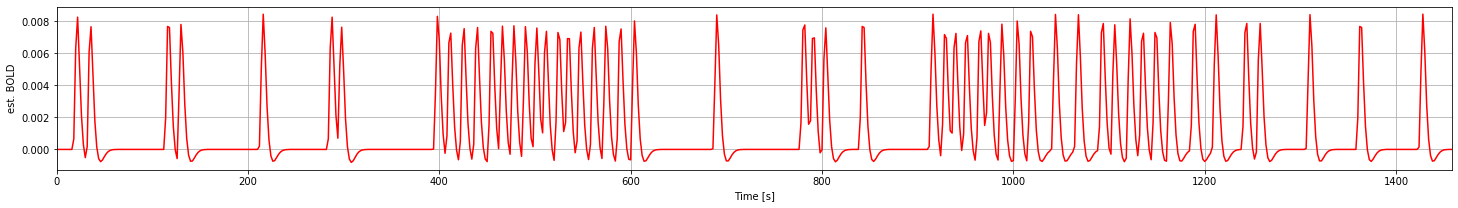

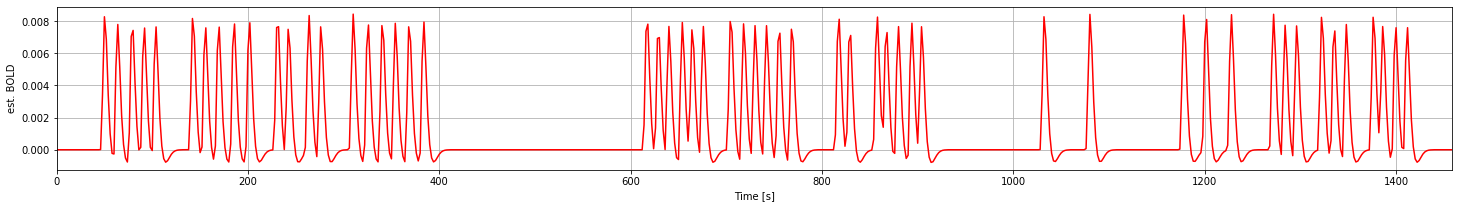

In [36]:
reg_lbp.plot_regressor()
reg_rbp.plot_regressor()

### Expected probability of winning

In [ ]:
dm, conditions = my_make_first_level_design_matrix(
    [reg_lbp, reg_rbp, reg_epw], confounds)

# Fit GLM
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=dm)

# Define contrast
conditions['epw']

# Compute statistical map and save it
z_map = fmri_glm.compute_contrast(
    conditions['epw'],
    stat_type='t')

z_map_fname = f"sub-{meta['dim1'][sub_idx]}_" + \
              f"task-prl{meta['dim2'][con_idx]}_desc-epw_tmap"
# nib.save(z_map, os.path.join(out_dir_epw, z_map_fname))

### Button press contrast

In [ ]:
dm, conditions = my_make_first_level_design_matrix(
    [reg_lbp, reg_rbp, reg_miss], confounds)

# Fit GLM
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=dm)

# Define contrast
left_minus_right = conditions['lbp'] - conditions['rbp']

# Compute statistical map and save it
z_map = fmri_glm.compute_contrast(
    left_minus_right,
    stat_type='t')

z_map_fname = f"sub-{meta['dim1'][sub_idx]}_" + \
              f"task-prl{meta['dim2'][con_idx]}_desc-buttonpress_tmap"
# nib.save(z_map, os.path.join(out_dir_btn, z_map_fname))

### Full prediction error

In [ ]:
dm, conditions = my_make_first_level_design_matrix(
    [reg_lbp, reg_rbp, reg_miss, reg_pe_full, reg_pe_miss],
    confounds
)

# Fit GLM
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=dm)

# Compute statistical map and save it
z_map = fmri_glm.compute_contrast(
    conditions['pe_full'],
    stat_type='t')

z_map_fname = f"sub-{meta['dim1'][sub_idx]}_" + \
              f"task-prl{meta['dim2'][con_idx]}_desc-pefull_tmap"
# nib.save(z_map, os.path.join(out_dir_pefull, z_map_fname))

### Prediction error sign

In [ ]:
dm, conditions = my_make_first_level_design_matrix(
    [reg_lbp, reg_rbp, reg_miss, reg_pe_sgn, reg_pe_miss],
    confounds
)

# Fit GLM
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=dm)

# Compute statistical map and save it
z_map = fmri_glm.compute_contrast(
    conditions['pe_sgn'],
    stat_type='t')

z_map_fname = f"sub-{meta['dim1'][sub_idx]}_" + \
              f"task-prl{meta['dim2'][con_idx]}_desc-pesign_tmap"
# nib.save(z_map, os.path.join(out_dir_pesign, z_map_fname))

### Prediction error absolute value (surprise)

In [ ]:
dm, conditions = my_make_first_level_design_matrix(
    [reg_lbp, reg_rbp, reg_miss, reg_pe_sur, reg_pe_miss],
    confounds
)

# Fit GLM
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=dm)

# Define contrast
conditions['pe_sur']

# Compute statistical map and save it
z_map = fmri_glm.compute_contrast(
    conditions['pe_sur'],
    stat_type='t')

z_map_fname = f"sub-{meta['dim1'][sub_idx]}_" + \
              f"task-prl{meta['dim2'][con_idx]}_desc-pesurp_tmap"
# nib.save(z_map, os.path.join(out_dir_pesurp, z_map_fname))

## Explore correlation between regressors

In [ ]:
# Calculate correlation between expected probability of winning and expected value
reg_corr = np.zeros((n_subjects, n_conditions))

for sub_idx in range(n_subjects):
    for con_idx in range(n_conditions):

        # Load decision phase regressors
        onset_dec = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_dec')] + \
            beh[sub_idx, con_idx, :, meta['dim4'].index('rt')]
        resp_type = beh[sub_idx, con_idx, :, meta['dim4'].index('response')]
        epw_regressor = epw_regressors[sub_idx, con_idx, resp_type != 0]
        erew_regressor = erew_regressors[sub_idx, con_idx, resp_type != 0]
        
        # Grab correlation between decision phase regressors
        reg_epw = Regressor('epw', frame_times, onset_dec[resp_type!=0], 
                            modulation=epw_regressor)
        reg_erew = Regressor('erew', frame_times, onset_dec[resp_type!=0],
                             modulation=erew_regressor)
        reg_corr[sub_idx, con_idx] = Regressor.corrcoef(reg_epw, reg_erew)